# PHYS 3317 -- Finite Differences with Magnetic Fields

<em> Lee Swindell </em>

### Animations

This module uses "Tk" to display some animations.  I tested it on a mac with the latest version of Enthought and the latest version of Anaconda.  It worked for me.  I also verified that it works on the lab computers.

If the following line does not work, then you will have difficulty with the animations.  You can still run the notebook, but some of the eye candy will be missing

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%gui tk

In [3]:
import Tkinter
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

class TDSEviewer2D(FigureCanvasTkAgg):
    """ TDSEviewer is a class for viewing 2D wavefunctions. 
    
    The wavefunction is stored in TDSEviewer.wavefunction

    To update the wavefunction (say setting it to "newwavefunction"), type
    viewer.wavefunction = newwavefunction
    viewer.update()
    (The figure is only updated once the second line is called)

    To close the figure type:
    viewer.close()
    """
    def __init__(self, master=None,wavefunction=None,potential=None,showpotential=None,title=None,dx=1):
        # if already have a root window (master) use it, otherwise create a new window
        if master==None:
            master=Tkinter.Tk()
        self.root=master
        
        # store input parameters
        self.wavefunction=wavefunction
        self.dx=dx
        
      
        # generate pylab figure
        fig = Figure() # generate figure object
        self.fig=fig   # store figure object for future reference
        ax=fig.add_subplot(111)
        if title!=None:
            ax.set_title(title)
            self.root.title(title)
        self.ax=ax
        self.im=ax.imshow(abs(wavefunction)**2)
        self.im.autoscale()
        
        # add pylab figure to window
        FigureCanvasTkAgg.__init__(self,fig,master=master)
        self.canvas = self
        self.canvas.show()
        self.canvas.get_tk_widget().pack(side='top', fill='both', expand=1)
        #frame.pack()
        #self.update()
        
    def update(self):
        """viewer.updatelines() redraws all of the lines"""
        
        self.im.set_data(abs(self.wavefunction)**2)
        self.im.autoscale()
        self.canvas.draw()
        #self.update()
        
    def set_title(self,title):
        """ viewer.set_title(title) sets the title"""
        self.ax.set_title(title)
        self.root.title(title)
        #self.canvas.draw()

        
    def close(self):
        self.root.destroy()


In [4]:
# This cell will open a window -- and it should have an image in it.

viewer=TDSEviewer2D(wavefunction=array([[1,0,1,0,1],
                                  [1,0,1,0,0],
                                  [1,1,1,0,1],
                                  [1,0,1,0,1],
                                  [1,0,1,0,1]
                                  ]))

TclError: 

In [ ]:
# This gives a title to the window

viewer.set_title("Hi")

In [ ]:
# This then closes it

viewer.close()

### Utilities

In [5]:
from __future__ import division  #get rid of integer division bug

In [6]:
from showmat import showmat #import function for printing matrices

### Finite Differences with Gauge Fields

We will use the finite difference approximation that we discussed in class:

$$\left(\nabla-iq{\bf A}\right)^2 \psi({\bf r})
\approx 
\sum_{\hat e} \frac{e^{i q {\bf A}\cdot \delta \hat e}\psi({\bf r}+\delta \hat e)-\psi({\bf r})}{\delta}
$$

where the sum is over all bonds coming from site $r$, and $A$ lives on the bonds.  IE.

$$(\nabla-i q A)^2 \psi(x,y)= \frac{1}{\delta}\left[e^{iq A_x(x+\delta/2,y)\delta}\psi(x+\delta,y)+e^{-iq A_x(x-\delta/2,y)\delta}\psi(x-\delta,y)+e^{iq A_y(x,y+\delta/2)\delta}\psi(x,y+\delta)+e^{-iq A_y(x,y-\delta/2)\delta}\psi(x,y-\delta)-4\psi(x,y)\right]$$

We will use a uniform magnetic field, where ${\bf \nabla\times A}=B {\bf \hat z}$ is a constant.

This condition does not uniquely define the vector potential.  One common choice is the "Landau Gauge" defined by

$$
\begin{array}{rcl}
A_x&=&0\cr
A_y&=&\phi x
\end{array}
$$

Here $\phi$ is a constant.

<b>Problem:</b>  How is $\phi$ related to $B$?  

$\phi$ is the strength of the B field

In [7]:
from scipy.sparse import *  # loads the required functions

In [8]:
#this function should look just like our "2d laplacian" function, 
# except it adds the phases
def makecovlaplacematrix(numgridpoints,dx,phi):
    """makelaplacematrix(numgridpoints,dx) returns a (numgridpoints^2)x(numgridpoints^2) square matrix
    which represents the operator $(\nabla-i q A)^2$ laplacian on the 2d grid with grid spacing dx.  
    It is in the dok_matrix format, and has hard wall boundary conditions.  The vector potential
    is in the Landau gauge, and corresponds to a uniform magnetic field."""
    numsites=numgridpoints**2
    covlaplace=dok_matrix((numsites,numsites),dtype=complex) # make a blank matrix for our Laplacian
    mesh=arange(numsites,dtype=integer).reshape(numgridpoints,numgridpoints)     # our indices laid out on a grid
    flatmesh=mesh.flatten()                       # our indices laid out in a line
    left=mesh[:,:-1].flatten()                    # the indices with the right column removed
    right=mesh[:,1:].flatten()                    # the indices with the left column removed
    bottom=mesh[:-1,:].flatten()                  # the indices with the top row removed
    top=mesh[1:,:].flatten()                      # the indices with the bottom row removed
    xvals=meshgrid(arange(len(mesh)),arange(len(mesh)))[0] # generate x on the grid
    topxvals=xvals[:-1,:]                         # take the x's with the bottom row removed
    phases=exp(1.j*phi*topxvals*dx**2).flatten()            # generate the phases on the hopping matrix element
    for key0,key1,phase in zip(top,bottom,phases):  # loop over the y-bonds
        covlaplace[key0,key1]=phase
        covlaplace[key1,key0]=conjugate(phase)
    for key0,key1 in zip(left,right):             # loop over the x-bonds
        covlaplace[key0,key1]=1.
        covlaplace[key1,key0]=1.
    for key in flatmesh:                             # loop over the sites to set the diagonal parts
        covlaplace[key,key]=-4.
    covlaplace=covlaplace/(dx**2)          # put in the factors of dx
    return csc_matrix(covlaplace)

The magnetic field gives phases on the "hopping" matrix elements of the Hamiltonian

In [9]:
showmat(makecovlaplacematrix(numgridpoints=5,dx=1,phi=1.).todense())

-4,1,,,,1,,,,,,,,,,,,,,,,,,,
1,-4,1,,,,0.54-0.84i,,,,,,,,,,,,,,,,,,
,1,-4,1,,,,-0.42-0.91i,,,,,,,,,,,,,,,,,
,,1,-4,1,,,,-0.99-0.14i,,,,,,,,,,,,,,,,
,,,1,-4,,,,,-0.65+0.76i,,,,,,,,,,,,,,,
1,,,,,-4,1,,,,1,,,,,,,,,,,,,,
,0.54+0.84i,,,,1,-4,1,,,,0.54-0.84i,,,,,,,,,,,,,
,,-0.42+0.91i,,,,1,-4,1,,,,-0.42-0.91i,,,,,,,,,,,,
,,,-0.99+0.14i,,,,1,-4,1,,,,-0.99-0.14i,,,,,,,,,,,
,,,,-0.65-0.76i,,,,1,-4,,,,,-0.65+0.76i,,,,,,,,,,
,,,,,1,,,,,-4,1,,,,1,,,,,,,,,


<b> Problem:</b> What happens if I take $\phi=2\pi/dx^2$?  Hint -- just try it

The complex part of the hopped up and down terms goes away

In [10]:
showmat(makecovlaplacematrix(numgridpoints=5,dx=2,phi=2*pi/4).todense())

-1,0.25,,,,0.25,,,,,,,,,,,,,,,,,,,
0.25,-1,0.25,,,,0.25,,,,,,,,,,,,,,,,,,
,0.25,-1,0.25,,,,0.25,,,,,,,,,,,,,,,,,
,,0.25,-1,0.25,,,,0.25,,,,,,,,,,,,,,,,
,,,0.25,-1,,,,,0.25,,,,,,,,,,,,,,,
0.25,,,,,-1,0.25,,,,0.25,,,,,,,,,,,,,,
,0.25,,,,0.25,-1,0.25,,,,0.25,,,,,,,,,,,,,
,,0.25,,,,0.25,-1,0.25,,,,0.25,,,,,,,,,,,,
,,,0.25,,,,0.25,-1,0.25,,,,0.25,,,,,,,,,,,
,,,,0.25,,,,0.25,-1,,,,,0.25,,,,,,,,,,
,,,,,0.25,,,,,-1,0.25,,,,0.25,,,,,,,,,


Since magnetic fields are associated with phases going around small loops -- in a tight binding model there is a maximum magnetic field one can model.  One often talks about the "flux per plaquette" which is the amount of magnetic flux in one pixel of your tight binding model.  In the units we are using ($dx=1$) the number $\phi$ is a nice dimensionless measure of the flux per plaquette.

## Energy Eigenvalues

Lets compare the spectrum with and without the magnetic field

In [11]:
ham=-makecovlaplacematrix(25,2*pi/5,1)

In [12]:
nobham=-makecovlaplacematrix(25,2*pi/5,0)

Be careful -- this is a large matrix -- I wouldn't try to display it in its dense form.  [Though your computer can probably handle it.]

In [13]:
ham

<625x625 sparse matrix of type '<type 'numpy.complex128'>'
	with 3025 stored elements in Compressed Sparse Column format>

In [14]:
from scipy.sparse.linalg import eigsh  # load the function which calculates eigenvectors of hermitian matrices

Lets Calculate the eigenvalues.  The command %time tells you how long it took to do the calculation.  It should take a few seconds to diagonalize these big matrices

In [15]:
%time ev1=eigsh(ham, k=620, sigma=0.5536, return_eigenvectors=False)

CPU times: user 3.9 s, sys: 162 ms, total: 4.07 s
Wall time: 3.36 s


In [16]:
%time ev1x=eigsh(nobham, k=620, sigma=0., return_eigenvectors=False)

CPU times: user 5.25 s, sys: 167 ms, total: 5.41 s
Wall time: 4.66 s


In [17]:
ev1x.sort() # Sort Eigenvalues

One nice way to display this spectrum is to plot a histogram -- binning the energies, and asking how many states are in any given energy bin.  This is known as the "Density of States".

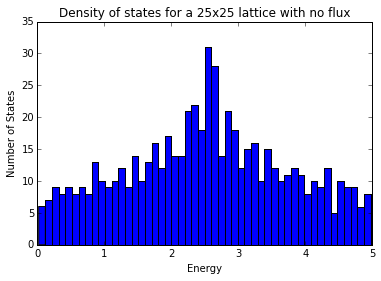

In [18]:
hist(ev1x,bins=50);  # Plot a histogram in absence
xlabel("Energy")
ylabel("Number of States")
title("Density of states for a 25x25 lattice with no flux")

As you can see, the density of states is quite flat, except for a spike in the center.  It turns out that this spike is an artifact of the finite difference approximation.  As we make the grid finer and finer, it will get pushed to higher energies.  [It is known as a Van-Hove singularity.]

Plot the density of states extracted from the energies in ev1.  Label your graph with a title "Density of states for a 25x25 lattice with flux per plaquette=1/5"  

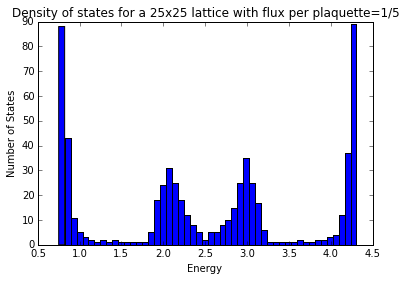

In [19]:
hist(ev1,bins=50);
xlabel("Energy")
ylabel("Number of States")
title("Density of states for a 25x25 lattice with flux per plaquette=1/5")

As you can see, adding the magnetic field broke the uniform density of states into narrow clumps.  In the homework you will analytically calculate this spectrum (without discretizing space).  You will find that the exact density of states should be a set of delta-functions.  The finite spread is again a feature of our finite differences approximation.

This clumping of energy levels is related to the fact that a charged particle in a uniform magnetic field undergoes cylcotron orbits, and the frequency of these orbits is independent of the radius or center.  There is a classical symmetry behind this -- this symmetry leads to a degeneracy.

These energies are known as "Landau levels"

An alternative way to plot the energies is to just line them up in order, and plot the energy vs eigenstate number

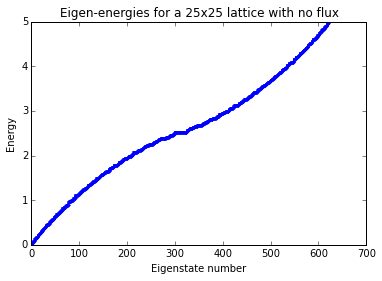

In [20]:
ev1x.sort()
plot(ev1x,marker=".")
xlabel("Eigenstate number")
ylabel("Energy")
title("Eigen-energies for a 25x25 lattice with no flux")

Do the same with ev1:  Change the label

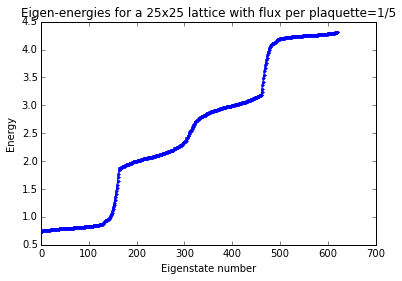

In [21]:
ev1.sort()
plot(ev1,marker=".")
xlabel("Eigenstate number")
ylabel("Energy")
title("Eigen-energies for a 25x25 lattice with flux per plaquette=1/5")

See those plateaus?  Those are the how the spikes in the histogram show up in this kind of graph. 

One interesting piece of physics here are the states which are sitting "between" the spikes?  These are "edge states" which are localized near the boundary.  Often physicists work with periodic boundary conditions to get rid of these edge states.  I think they are pretty cool.  These edge modes are associated with classical "skipping orbits"

Note: edge states are very "hot" right now in condensed matter physics.

We can look at one of these edge eigenstates by looking at the right energy:

In [22]:
energy1,state1=eigsh(ham, k=1, sigma=1.2, return_eigenvectors=True)

In [23]:
def twodrep(vec):
    """ twodrep reshapes a linear array into a square array"""
    size=sqrt(len(vec)) # How many psi's do we have
    ans=vec.copy() # So as not to cause any nasty side-effects, lets copy the array
    return ans.reshape(size,size) # reshape

In [24]:
energy1

array([ 1.21010892])

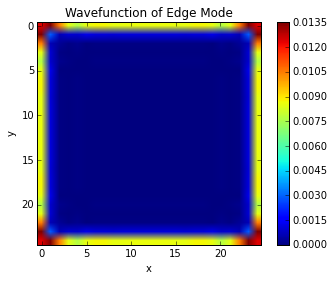

In [25]:
imshow(abs(twodrep(state1))**2)
colorbar()
xlabel("x")
ylabel("y")
title("Wavefunction of Edge Mode")

As you can see, the mode is localized near the edges.

Here is an alternative way to plot it.  I am afraid the syntax is not very friendly:

In [26]:
from mpl_toolkits.mplot3d import Axes3D

In [27]:
sqrt(len(state1))

25.0

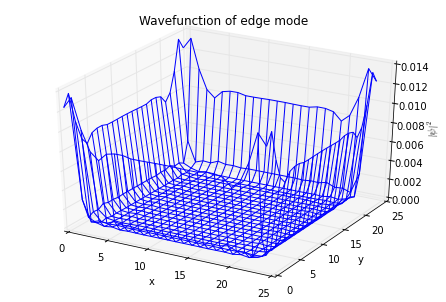

In [28]:
fig=figure()
ax=Axes3D(fig)
xvals=arange(25)
yvals=arange(25)
x,y=meshgrid(xvals,yvals)
wf=ax.plot_wireframe(x,y,abs(twodrep(state1))**2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$|\psi|^2$")
title("Wavefunction of edge mode")

We can contrast this to the bulk modes.  Lets take the states corresponding to the lowest 90 energies.

In [29]:
energy2,state2=eigsh(ham, k=90, sigma=0.5536, return_eigenvectors=True)

If we plot a histogram of these states, we see all of the energies are in one "Landau Level".

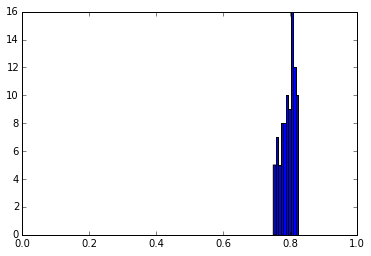

In [30]:
hist(energy2,bins=10);
xlim([0,1]);

Lets plot the sum of the absolute value squared of all of these wavefunctions.  This would, for example, represent the density if we had fermions in all these states.

In [31]:
state2array=array(state2)

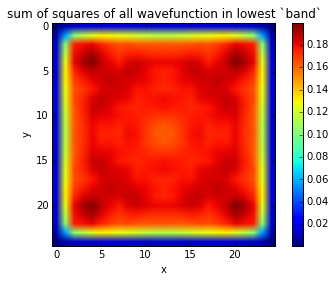

In [32]:
imshow(twodrep((abs(state2)**2).sum(axis=1)))
colorbar()
xlabel("x")
ylabel("y")
title("sum of squares of all wavefunction in lowest `band`")

That is so nuts!  Essentially the density is flat, falling to zero at the edge.

For something fun, we can plot the individual states.  Note -- these are not particularly relevant.  Since all these states are nearly degenerate, linear combinations of them are also pretty well eigenstates.  On the other hand, they are really pretty. 

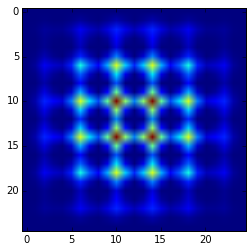

In [33]:
imshow(abs(twodrep(state2[:,0]))**2)

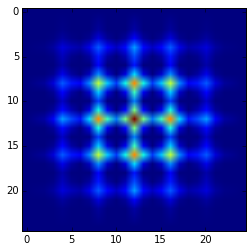

In [34]:
imshow(abs(twodrep(state2[:,1]))**2)

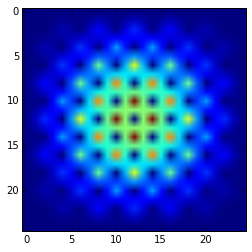

In [35]:
imshow(abs(twodrep(state2[:,2]))**2)

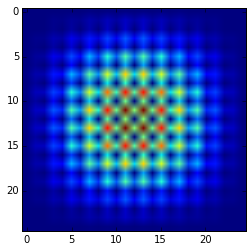

In [36]:
imshow(abs(twodrep(state2[:,3]))**2)

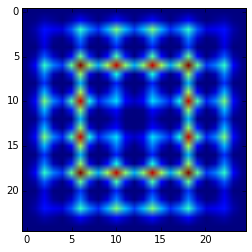

In [37]:
imshow(abs(twodrep(state2[:,4]))**2)

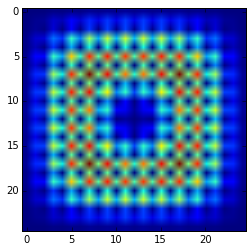

In [38]:
imshow(abs(twodrep(state2[:,5]))**2)

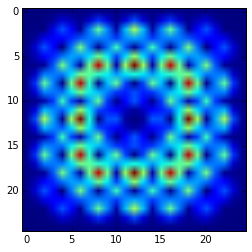

In [39]:
imshow(abs(twodrep(state2[:,6]))**2)

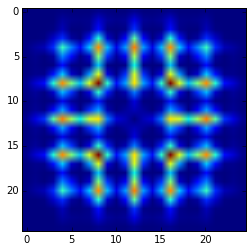

In [40]:
imshow(abs(twodrep(state2[:,7]))**2)

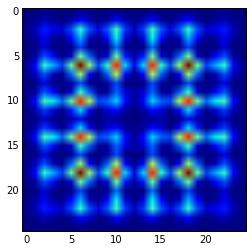

In [41]:
imshow(abs(twodrep(state2[:,8]))**2)

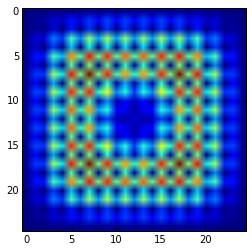

In [42]:
imshow(abs(twodrep(state2[:,9]))**2)

Lets contrast these with the states in the absense of magnetic field

In [43]:
energy3,state3=eigsh(nobham, k=9, sigma=0., return_eigenvectors=True)

In [44]:
energy3*(25*2*pi/15)**2

array([  2.02531275,   5.04851507,   8.07171738,   5.04851507,
        10.03817822,  10.03817822,  13.06138054,  13.06138054,  16.9215417 ])

In [45]:
[1+1,4+1,1+4,4+4,9+1,1+9,4+9,9+4,16+1]

[2, 5, 5, 8, 10, 10, 13, 13, 17]

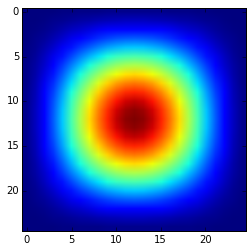

In [46]:
imshow(abs(twodrep(state3[:,0]))**2)

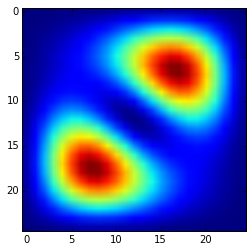

In [47]:
imshow(abs(twodrep(state3[:,1]))**2)

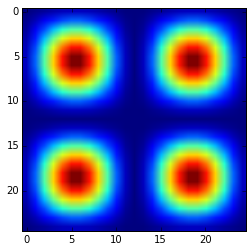

In [48]:
imshow(abs(twodrep(state3[:,2]))**2)

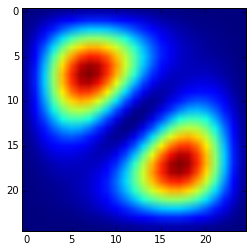

In [49]:
imshow(abs(twodrep(state3[:,3]))**2)

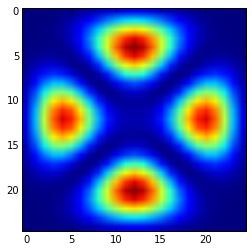

In [50]:
imshow(abs(twodrep(state3[:,4]))**2)

<b> Problem </b>  Plot the density of an edge state for the same 25x25 lattice, but this time with half as strong of a magnetic field.

In [51]:
ham_1=-makecovlaplacematrix(25,2*pi/5,.5)
energy_1,state_1=eigsh(ham_1, k=1, sigma=1.2, return_eigenvectors=True)

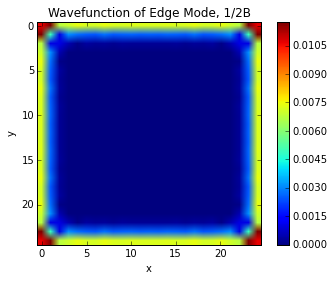

In [52]:
imshow(abs(twodrep(state_1))**2)
colorbar()
xlabel("x")
ylabel("y")
title("Wavefunction of Edge Mode, 1/2B")

<b> Problem:</b>  Do you see any differences between the edge states in these two cases?  Does it make sense?  Why?

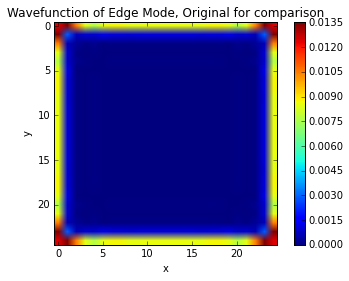

In [61]:
imshow(abs(twodrep(state1))**2)
colorbar()
xlabel("x")
ylabel("y")
title("Wavefunction of Edge Mode, Original for comparison")

<em> The wavefunction with half the magnetic field looks less tightly bound to the edges. This makes sense since the magnetic field determines the radius of the small circular motions. A smaller magnetic field is a larger radius </em>

## Time Dependence

We can do time dependence by sequentially solving the equation

$$\left(1+iH \delta t/2\right) \psi(t+\delta t)=\left(1-iH\delta t/2\right)\psi(t)$$

Here is some code for opening a window, for showing animations of the wavefunctions.  [I copied this to the top of the notebook.]

In [63]:
%gui tk

In [55]:
import Tkinter
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

class TDSEviewer2D(FigureCanvasTkAgg):
    """ TDSEviewer is a class for viewing 2D wavefunctions. 
    
    The wavefunction is stored in TDSEviewer.wavefunction

    To update the wavefunction (say setting it to "newwavefunction"), type
    viewer.wavefunction = newwavefunction
    viewer.update()
    (The figure is only updated once the second line is called)

    To close the figure type:
    viewer.close()
    """
    def __init__(self, master=None,wavefunction=None,potential=None,showpotential=None,title=None,dx=1):
        # if already have a root window (master) use it, otherwise create a new window
        if master==None:
            master=Tkinter.Tk()
        self.root=master
        
        # store input parameters
        self.wavefunction=wavefunction
        self.dx=dx
        
      
        # generate pylab figure
        fig = Figure() # generate figure object
        self.fig=fig   # store figure object for future reference
        ax=fig.add_subplot(111)
        if title!=None:
            ax.set_title(title)
            self.root.title(title)
        self.ax=ax
        self.im=ax.imshow(abs(wavefunction)**2)
        self.im.autoscale()
        
        # add pylab figure to window
        FigureCanvasTkAgg.__init__(self,fig,master=master)
        self.canvas = self
        self.canvas.show()
        self.canvas.get_tk_widget().pack(side='top', fill='both', expand=1)
        #frame.pack()
        #self.update()
        
    def update(self):
        """viewer.updatelines() redraws all of the lines"""
        
        self.im.set_data(abs(self.wavefunction)**2)
        self.im.autoscale()
        self.canvas.draw()
        #self.update()
        
    def set_title(self,title):
        """ viewer.set_title(title) sets the title"""
        self.ax.set_title(title)
        self.root.title(title)
        #self.canvas.draw()

        
    def close(self):
        self.root.destroy()


The following lines illustrate how this object works

In [56]:
viewer=TDSEviewer2D(wavefunction=twodrep(state3[:,0]))

TclError: 

In [57]:
viewer.wavefunction=twodrep(state3[:,1])

NameError: name 'viewer' is not defined

In [58]:
viewer.update()

NameError: name 'viewer' is not defined

In [59]:
viewer.set_title("hi")

NameError: name 'viewer' is not defined

In [60]:
viewer.close()

NameError: name 'viewer' is not defined

Now lets recall our time stepping algorithm

In [53]:
import scipy.sparse.linalg as linalg
import scipy.sparse as sparse

$$\left(1+iH \delta t/2\right) \psi(t+\delta t)=\left(1-iH\delta t/2\right)\psi(t)$$

First lets do the case of no magnetic field

In [61]:
dt=0.1  # set time step
dx=2*pi/5 # set lattice spacing
ln=100 # set number of lattice points
ham=-makecovlaplacematrix(ln,dx,0) # make hamiltonian
csrham=csr_matrix(ham)  # convert to more efficient format
hamsize=ham.shape[0]
LHSOperator=sparse.identity(hamsize,dtype=complex,format="csr")+0.5j*dt*csrham
inverseLHS=linalg.factorized(LHSOperator) 
RHSOperator=sparse.identity(hamsize,dtype=complex,format="csr")-0.5j*dt*csrham

/Applications/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:228: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [62]:
def gauswf(x0,y0,axx,axy,ayy,bx,by,numpoints,dx):
    def gausfun(xint,yint):
        x=xint*dx
        y=yint*dx
        return exp(-axx*(x-x0)**2-2*axy*(x-x0)*(y-y0)-ayy*(y-y0)**2-1.j*bx*x-1.j*by*y) 
    return fromfunction(gausfun,shape=(numpoints,numpoints))

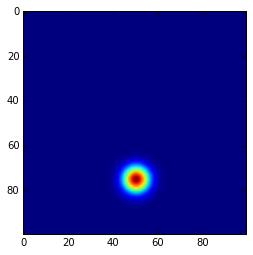

In [63]:
wf2=gauswf(ln*dx*3/4,ln*dx/2,0.01,0.j,0.01,pi/(2*dx),pi/(2*dx),ln,dx)
imshow(abs(wf2)**2)

In [64]:
state=wf2.flatten()

In [65]:
viewer=TDSEviewer2D(wavefunction=wf2)

TclError: 

In [66]:
t=0
while t<200:
    s=0
    while s<1:
        state=inverseLHS(RHSOperator.dot(state))
        t+=dt
        s+=dt
    viewer.wavefunction=twodrep(state)
    viewer.set_title(str(t))
    viewer.update()

NameError: name 'viewer' is not defined

<b> Problem</b> In words explain what you just saw.  Does it seem sensible.

the particle bounces around the walls. it makes sense since theres no applied field so all it has is kinetic energy.

Now lets do the same with a magnetic field

In [67]:
viewer.set_title("t=0")

NameError: name 'viewer' is not defined

In [68]:
dt=0.1  # set time step
dx=1
#ln=25
ln=100
phi=0.02*pi
ham=-makecovlaplacematrix(ln,dx,phi)  # make hamiltonian
#ham=-makelaplacematrix(ln,dx)
csrham=csr_matrix(ham)  # convert to more efficient format
hamsize=ham.shape[0]
LHSOperator=sparse.identity(hamsize,dtype=complex,format="csr")+0.5j*dt*csrham
inverseLHS=linalg.factorized(LHSOperator) 
RHSOperator=sparse.identity(hamsize,dtype=complex,format="csr")-0.5j*dt*csrham

In [69]:
def gauswf(x0,y0,axx,axy,ayy,bx,by,numpoints,dx):
    def gausfun(xint,yint):
        x=xint*dx
        y=yint*dx
        return exp(-axx*(x-x0)**2-2*axy*(x-x0)*(y-y0)-ayy*(y-y0)**2-1.j*bx*x-1.j*by*y) 
    return fromfunction(gausfun,shape=(numpoints,numpoints))

In [70]:
wf2=gauswf(ln*dx*0.5,ln*dx/2,0.005*pi,-0.005j*pi,0.005*pi,pi/dx,0.4*pi/(2*dx),ln,dx)

In [71]:
state=wf2.flatten()
viewer.wavefunction=twodrep(state)
viewer.update()

NameError: name 'viewer' is not defined

In [72]:
t=0
while t<100:
    s=0
    while s<1:
        state=inverseLHS(RHSOperator.dot(state))
        t+=dt
        s+=dt
    viewer.wavefunction=twodrep(state)
    viewer.set_title(str(t))
    viewer.update()

NameError: name 'viewer' is not defined

<b> Problem:</b> Explain in words how that behavior is consistent with the motion of a particle in a magetic field.

It follows a circular path, which is what a particle does when moving through a uniform magnetic field; this comes from setting mv^2/r = qvxB 